In [1]:
# ============================================================================
# TASK 4: Training Variational Autoencoders on FashionMNIST
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# ARCHITECTURE DEFINITION (from provided architecture.py)
# ============================================================================

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)  # 28x28 -> 14x14
        self.enc_conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1) # 14x14 -> 7x7
        self.enc_fc = nn.Linear(64*7*7, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 256)
        self.dec_fc2 = nn.Linear(256, 64*7*7)
        self.dec_deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1) # 7x7 -> 14x14
        self.dec_deconv2 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)  # 14x14 -> 28x28

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)
        h = F.relu(self.enc_fc(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.dec_fc(z))
        h = F.relu(self.dec_fc2(h))
        h = h.view(-1, 64, 7, 7)
        h = F.relu(self.dec_deconv1(h))
        x_recon = torch.sigmoid(self.dec_deconv2(h))
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


Using device: cuda


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.46MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.4MB/s]


Training samples: 60000
Test samples: 10000
Model architecture:
VAE(
  (enc_conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_fc): Linear(in_features=3136, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=20, bias=True)
  (dec_fc): Linear(in_features=20, out_features=256, bias=True)
  (dec_fc2): Linear(in_features=256, out_features=3136, bias=True)
  (dec_deconv1): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_deconv2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

Total parameters: 1691369
Training standard VAE...
Epoch   0: Train Loss: 37.7929 (Recon: 32.0004, KL: 5.7924) | Val Loss: 28.2878 (Recon: 21.7362, KL: 6.5516)
Epoch  10: Train Loss: 23.7258 (Recon: 16.0708, KL: 7.6550) | Val Loss: 23.7478 (Recon: 16.1807, 

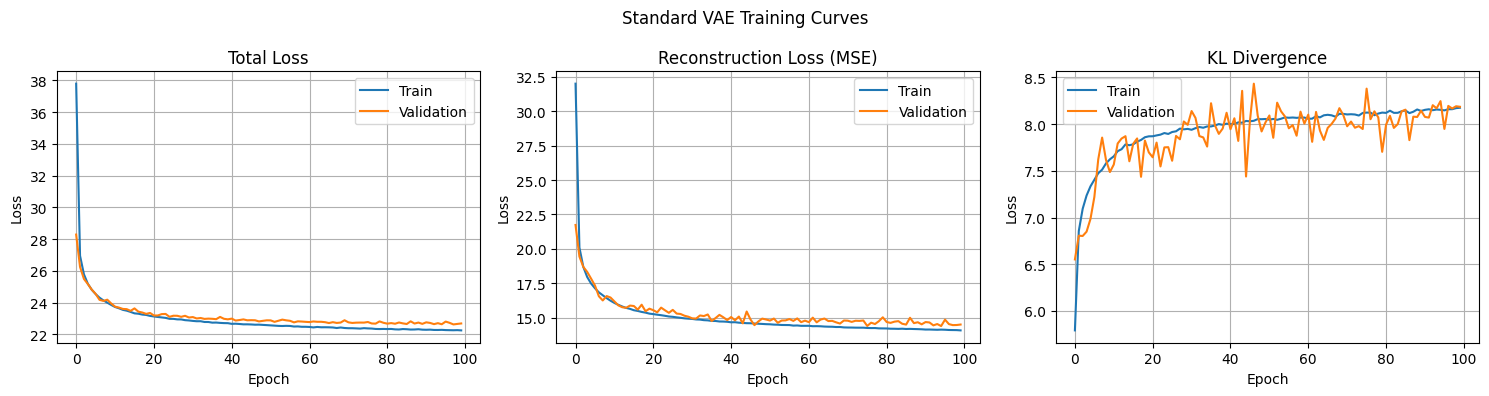

In [2]:
# ============================================================================
# TASK 4.1: TRAINING THE VAE
# ============================================================================

# (a) Download FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1], then we'll rescale
])

# Note: We'll actually use [0, 1] range for compatibility with sigmoid output
transform_01 = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform_01
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform_01
)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# (c) Define loss function
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss = Reconstruction Loss + β * KL Divergence
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    # KL(q(z|x) || p(z)) where p(z) = N(0, I)
    # KL = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_div, recon_loss, kl_div

# Initialize model
model = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Training function
def train_vae(model, train_loader, test_loader, epochs=50, beta=1.0):
    model.train()
    train_losses = []
    train_recon_losses = []
    train_kl_losses = []
    val_losses = []
    val_recon_losses = []
    val_kl_losses = []

    for epoch in range(epochs):
        total_loss = 0
        total_recon = 0
        total_kl = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()

        avg_train_loss = total_loss / len(train_dataset)
        avg_train_recon = total_recon / len(train_dataset)
        avg_train_kl = total_kl / len(train_dataset)

        train_losses.append(avg_train_loss)
        train_recon_losses.append(avg_train_recon)
        train_kl_losses.append(avg_train_kl)

        # Validation
        model.eval()
        val_loss = 0
        val_recon = 0
        val_kl = 0

        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
                val_loss += loss.item()
                val_recon += recon_loss.item()
                val_kl += kl_loss.item()

        avg_val_loss = val_loss / len(test_dataset)
        avg_val_recon = val_recon / len(test_dataset)
        avg_val_kl = val_kl / len(test_dataset)

        val_losses.append(avg_val_loss)
        val_recon_losses.append(avg_val_recon)
        val_kl_losses.append(avg_val_kl)

        model.train()

        if epoch % 10 == 0:
            print(f'Epoch {epoch:3d}: Train Loss: {avg_train_loss:.4f} '
                  f'(Recon: {avg_train_recon:.4f}, KL: {avg_train_kl:.4f}) | '
                  f'Val Loss: {avg_val_loss:.4f} '
                  f'(Recon: {avg_val_recon:.4f}, KL: {avg_val_kl:.4f})')

    return (train_losses, train_recon_losses, train_kl_losses,
            val_losses, val_recon_losses, val_kl_losses)

# (d) Train the VAE and record losses
print("Training standard VAE...")
results_standard = train_vae(model, train_loader, test_loader, epochs=100, beta=1.0)

# Plot training curves
def plot_training_curves(results, title="VAE Training Curves"):
    train_losses, train_recon_losses, train_kl_losses, val_losses, val_recon_losses, val_kl_losses = results

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Total loss
    axes[0].plot(train_losses, label='Train')
    axes[0].plot(val_losses, label='Validation')
    axes[0].set_title('Total Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Reconstruction loss
    axes[1].plot(train_recon_losses, label='Train')
    axes[1].plot(val_recon_losses, label='Validation')
    axes[1].set_title('Reconstruction Loss (MSE)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    # KL divergence
    axes[2].plot(train_kl_losses, label='Train')
    axes[2].plot(val_kl_losses, label='Validation')
    axes[2].set_title('KL Divergence')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    axes[2].grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_training_curves(results_standard, "Standard VAE Training Curves")


Visualizing reconstructions...


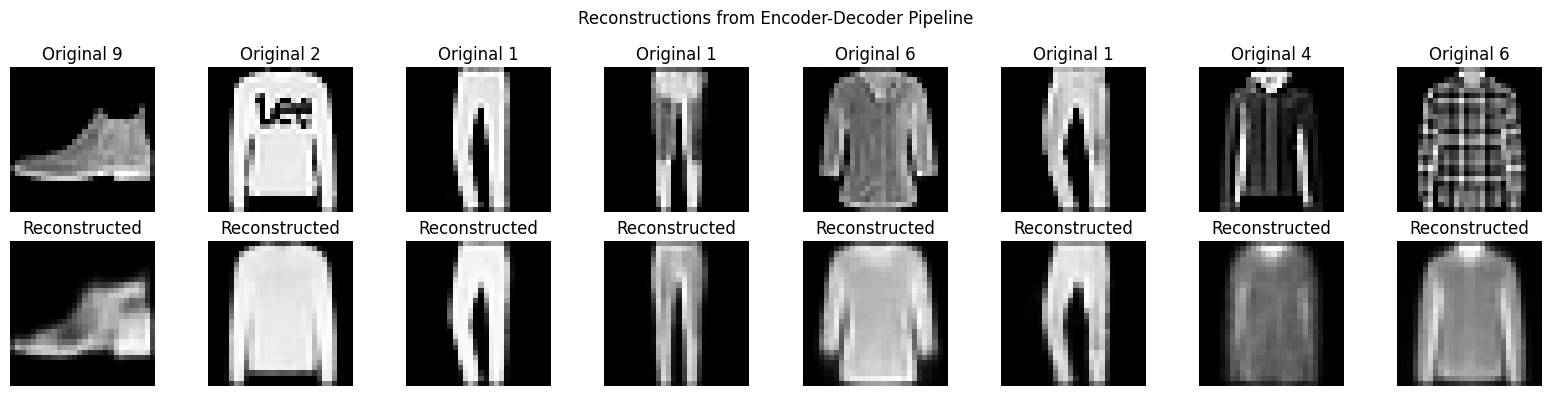

Generating samples from normal prior...


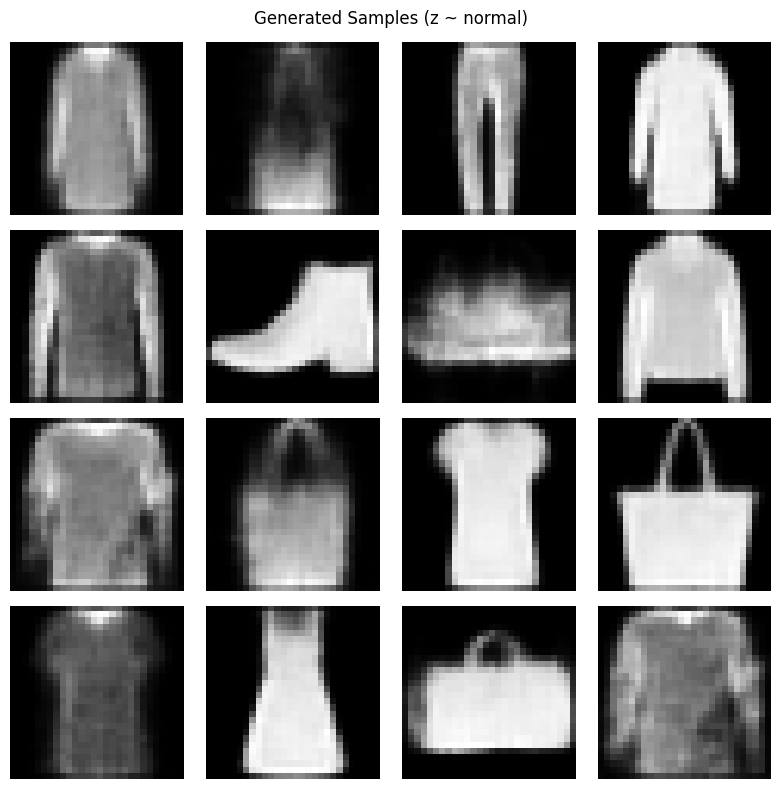

Generating samples from Laplacian prior...


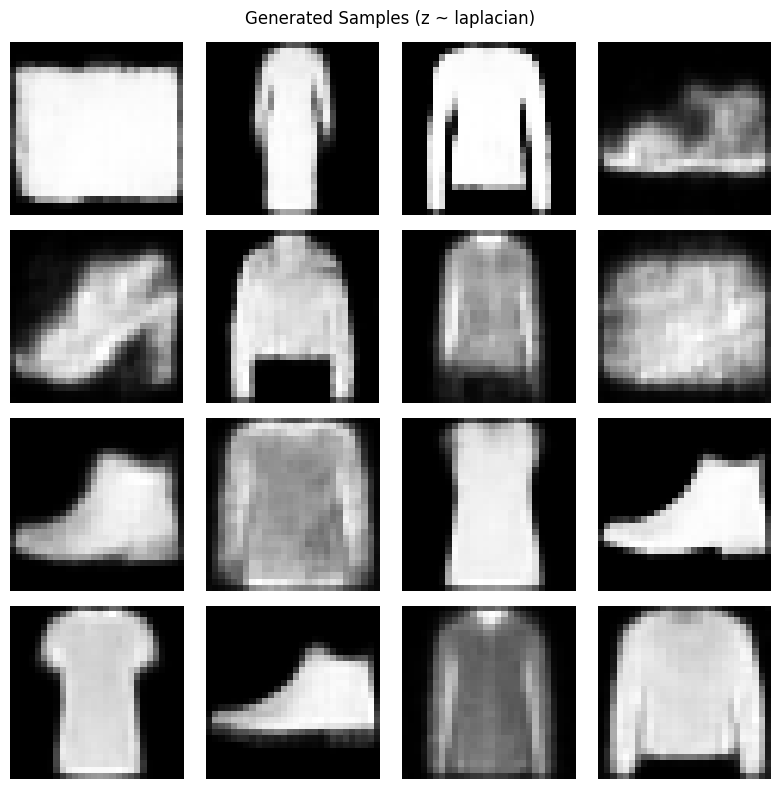

In [3]:

# ============================================================================
# TASK 4.2: VISUALIZE RECONSTRUCTIONS AND GENERATIONS
# ============================================================================

def visualize_reconstructions(model, test_loader, num_samples=8):
    model.eval()
    with torch.no_grad():
        # Get a batch of test data
        data, labels = next(iter(test_loader))
        data = data[:num_samples].to(device)

        # Reconstruct
        recon_data, mu, logvar = model(data)

        # Plot original vs reconstructed
        fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*2, 4))

        for i in range(num_samples):
            # Original
            axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
            axes[0, i].set_title(f'Original {labels[i].item()}')
            axes[0, i].axis('off')

            # Reconstructed
            axes[1, i].imshow(recon_data[i].cpu().squeeze(), cmap='gray')
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')

        plt.suptitle('Reconstructions from Encoder-Decoder Pipeline')
        plt.tight_layout()
        plt.show()

# (a) Visualize reconstructions
print("Visualizing reconstructions...")
visualize_reconstructions(model, test_loader)

def generate_samples(model, num_samples=16, latent_dim=20, distribution='normal'):
    model.eval()
    with torch.no_grad():
        if distribution == 'normal':
            # Sample from standard normal distribution
            z = torch.randn(num_samples, latent_dim).to(device)
        elif distribution == 'laplacian':
            # Sample from Laplacian distribution
            # Laplacian(0, 1) can be generated using inverse CDF
            u = torch.rand(num_samples, latent_dim).to(device)
            z = torch.where(u < 0.5,
                           torch.log(2 * u),
                           -torch.log(2 * (1 - u)))
        else:
            raise ValueError("Distribution must be 'normal' or 'laplacian'")

        # Generate samples
        samples = model.decode(z)

        # Plot samples
        grid_size = int(np.sqrt(num_samples))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))

        for i in range(num_samples):
            row = i // grid_size
            col = i % grid_size
            axes[row, col].imshow(samples[i].cpu().squeeze(), cmap='gray')
            axes[row, col].axis('off')

        plt.suptitle(f'Generated Samples (z ~ {distribution})')
        plt.tight_layout()
        plt.show()

# (b) Generate samples from normal prior
print("Generating samples from normal prior...")
generate_samples(model, num_samples=16, distribution='normal')

# (c) Generate samples from Laplacian prior
print("Generating samples from Laplacian prior...")
generate_samples(model, num_samples=16, distribution='laplacian')


Analyzing posterior collapse for standard VAE...
Posterior Collapse Analysis:
Mean μ across all samples: -0.006281 ± 0.022952
Mean log σ² across all samples: -0.818051 ± 1.456616
Mean σ across all samples: 0.796880 ± 0.330391
Ratio of posterior variances close to 1.0 (±0.1): 0.705


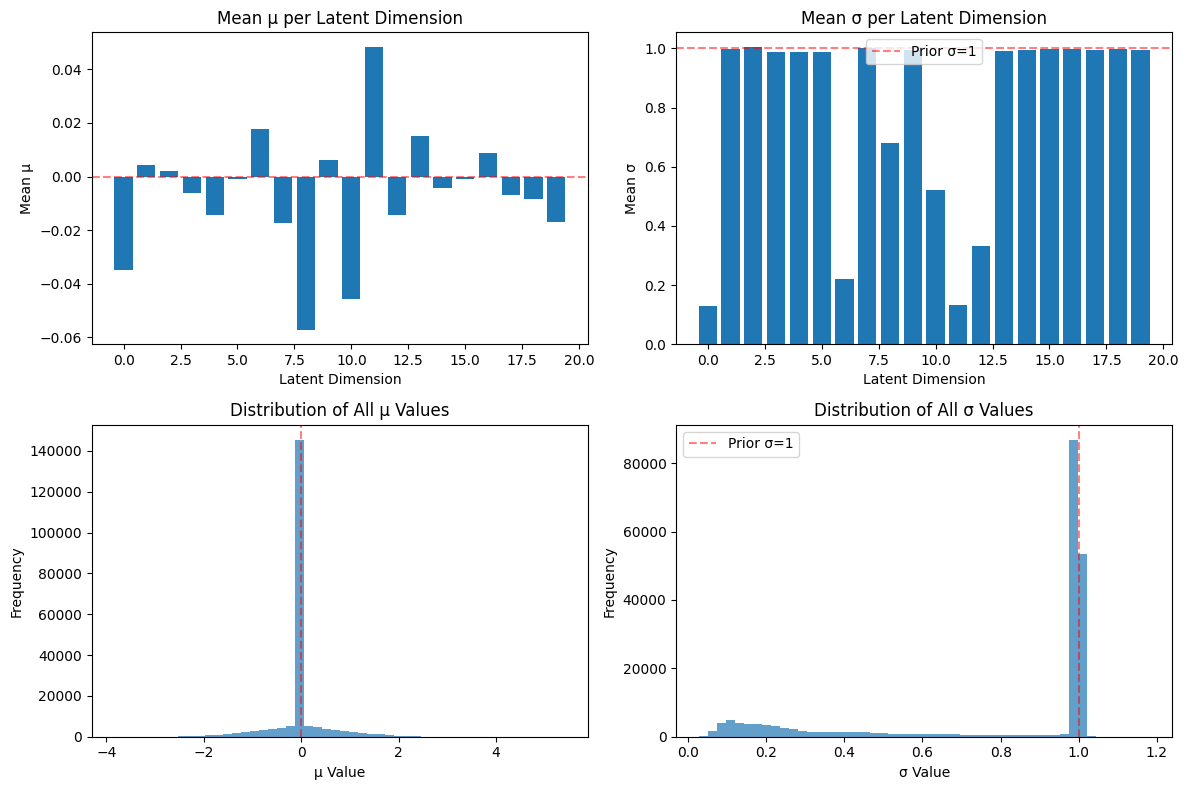

In [4]:

# ============================================================================
# TASK 4.3: POSTERIOR COLLAPSE INVESTIGATION
# ============================================================================

def analyze_posterior_collapse(model, test_loader):
    """Analyze if posterior collapse is occurring"""
    model.eval()
    all_mus = []
    all_logvars = []

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            mu, logvar = model.encode(data)
            all_mus.append(mu.cpu())
            all_logvars.append(logvar.cpu())

    all_mus = torch.cat(all_mus, dim=0)
    all_logvars = torch.cat(all_logvars, dim=0)

    # Calculate statistics
    mu_mean = all_mus.mean(dim=0)
    mu_std = all_mus.std(dim=0)
    logvar_mean = all_logvars.mean(dim=0)
    std_mean = torch.exp(0.5 * all_logvars).mean(dim=0)

    print("Posterior Collapse Analysis:")
    print(f"Mean μ across all samples: {mu_mean.mean().item():.6f} ± {mu_mean.std().item():.6f}")
    print(f"Mean log σ² across all samples: {logvar_mean.mean().item():.6f} ± {logvar_mean.std().item():.6f}")
    print(f"Mean σ across all samples: {std_mean.mean().item():.6f} ± {std_mean.std().item():.6f}")

    # Check if variances are close to 1 (indicating collapse to prior)
    posterior_vars = torch.exp(all_logvars)
    var_close_to_one = torch.abs(posterior_vars - 1.0) < 0.1
    collapse_ratio = var_close_to_one.float().mean().item()
    print(f"Ratio of posterior variances close to 1.0 (±0.1): {collapse_ratio:.3f}")

    # Visualize latent space statistics
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Mean values per dimension
    axes[0, 0].bar(range(len(mu_mean)), mu_mean.numpy())
    axes[0, 0].set_title('Mean μ per Latent Dimension')
    axes[0, 0].set_xlabel('Latent Dimension')
    axes[0, 0].set_ylabel('Mean μ')
    axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

    # Standard deviation per dimension
    axes[0, 1].bar(range(len(std_mean)), std_mean.numpy())
    axes[0, 1].set_title('Mean σ per Latent Dimension')
    axes[0, 1].set_xlabel('Latent Dimension')
    axes[0, 1].set_ylabel('Mean σ')
    axes[0, 1].axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Prior σ=1')
    axes[0, 1].legend()

    # Distribution of μ values
    axes[1, 0].hist(all_mus.flatten().numpy(), bins=50, alpha=0.7)
    axes[1, 0].set_title('Distribution of All μ Values')
    axes[1, 0].set_xlabel('μ Value')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(x=0, color='r', linestyle='--', alpha=0.5)

    # Distribution of σ values
    axes[1, 1].hist(torch.exp(0.5 * all_logvars).flatten().numpy(), bins=50, alpha=0.7)
    axes[1, 1].set_title('Distribution of All σ Values')
    axes[1, 1].set_xlabel('σ Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(x=1, color='r', linestyle='--', alpha=0.5, label='Prior σ=1')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    return collapse_ratio

print("Analyzing posterior collapse for standard VAE...")
collapse_ratio_standard = analyze_posterior_collapse(model, test_loader)



Training VAE with β-annealing to mitigate posterior collapse...
Epoch   0 (β=0.000): Train Loss: 25.4990 (Recon: 25.4990, KL: 272.6809) | Val Loss: 14.3202 (Recon: 14.3202, KL: 365.2714)
Epoch  10 (β=0.000): Train Loss: 6.9744 (Recon: 6.9744, KL: 345.9177) | Val Loss: 7.1873 (Recon: 7.1873, KL: 347.0465)
Epoch  20 (β=0.000): Train Loss: 6.2932 (Recon: 6.2932, KL: 323.3403) | Val Loss: 6.6039 (Recon: 6.6039, KL: 324.2064)
Epoch  30 (β=0.000): Train Loss: 5.9685 (Recon: 5.9685, KL: 323.8886) | Val Loss: 6.4822 (Recon: 6.4822, KL: 324.6139)
Epoch  40 (β=0.000): Train Loss: 5.7535 (Recon: 5.7535, KL: 338.4536) | Val Loss: 6.3564 (Recon: 6.3564, KL: 329.8081)
Epoch  50 (β=0.000): Train Loss: 5.6071 (Recon: 5.6071, KL: 343.3542) | Val Loss: 6.2559 (Recon: 6.2559, KL: 343.9742)
Epoch  60 (β=0.200): Train Loss: 13.8526 (Recon: 8.2718, KL: 27.9041) | Val Loss: 14.2985 (Recon: 8.8678, KL: 27.1534)
Epoch  70 (β=0.400): Train Loss: 17.1400 (Recon: 10.4460, KL: 16.7350) | Val Loss: 17.4457 (Recon:

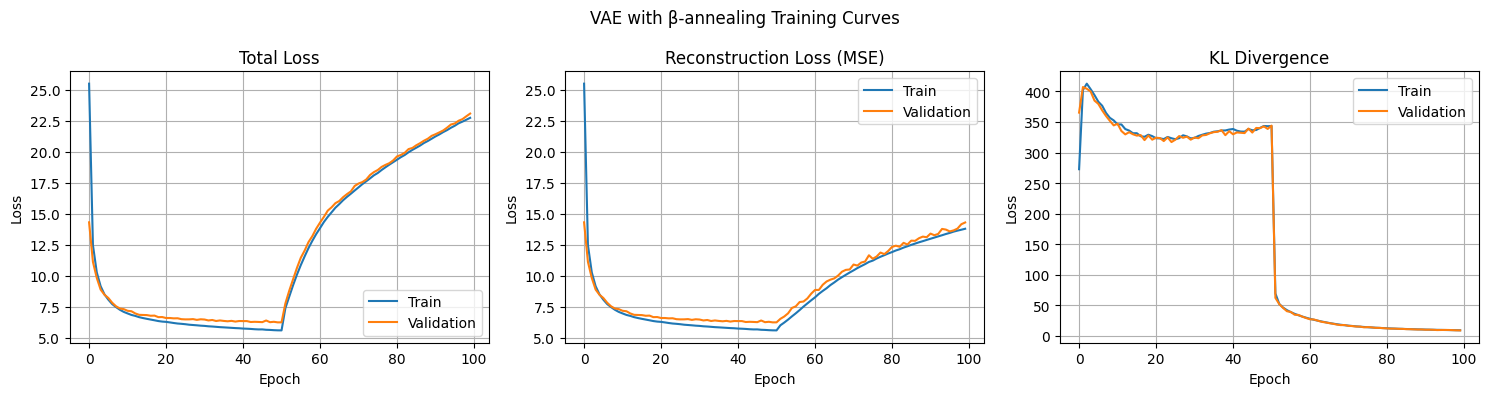

Comparing standard VAE vs β-annealed VAE...

Reconstructions - Standard VAE:


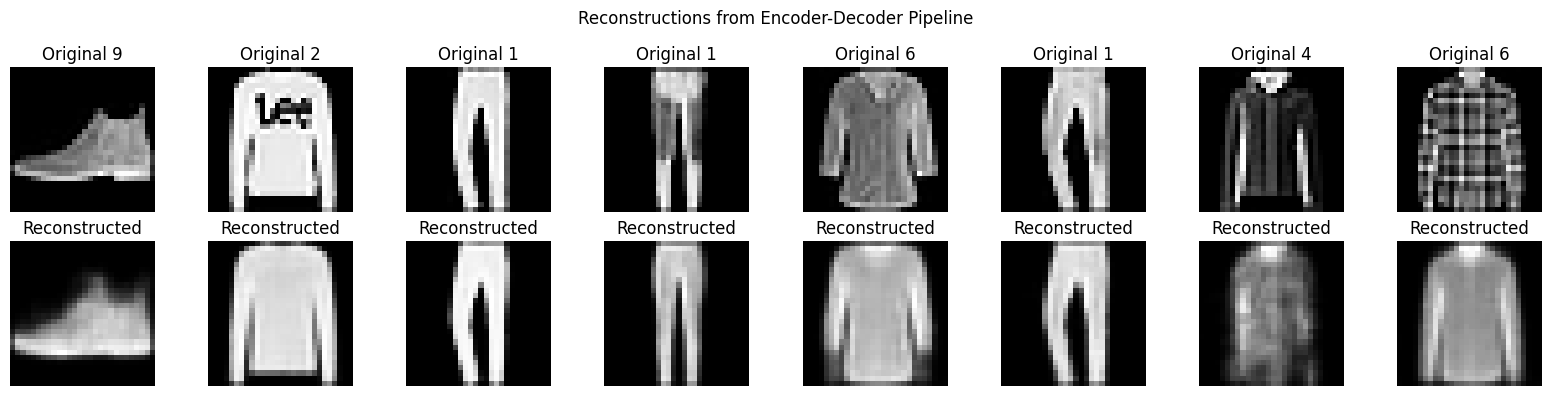

Reconstructions - β-annealed VAE:


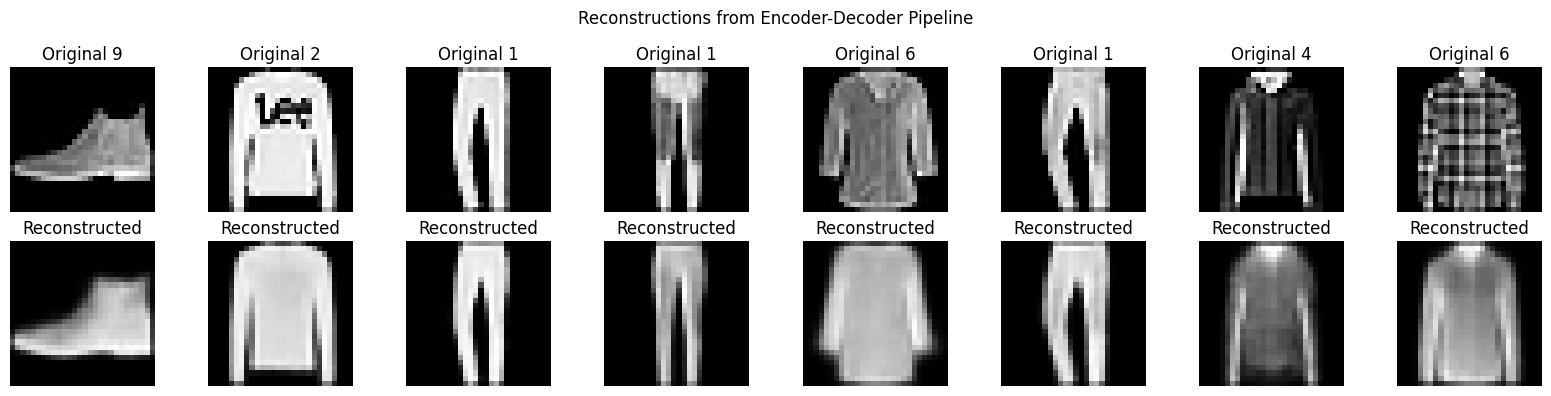

Generations - Standard VAE:


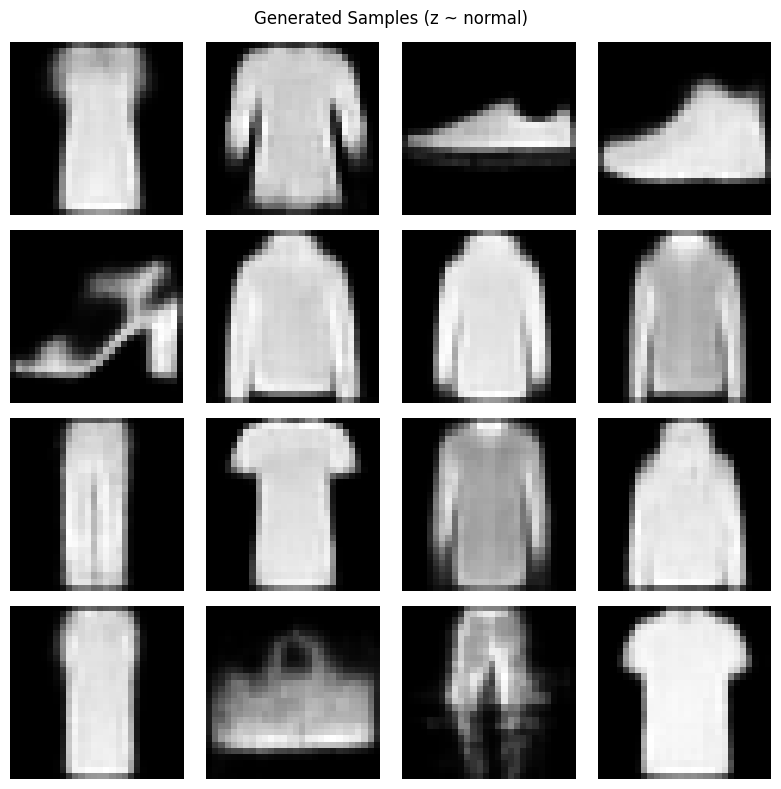

Generations - β-annealed VAE:


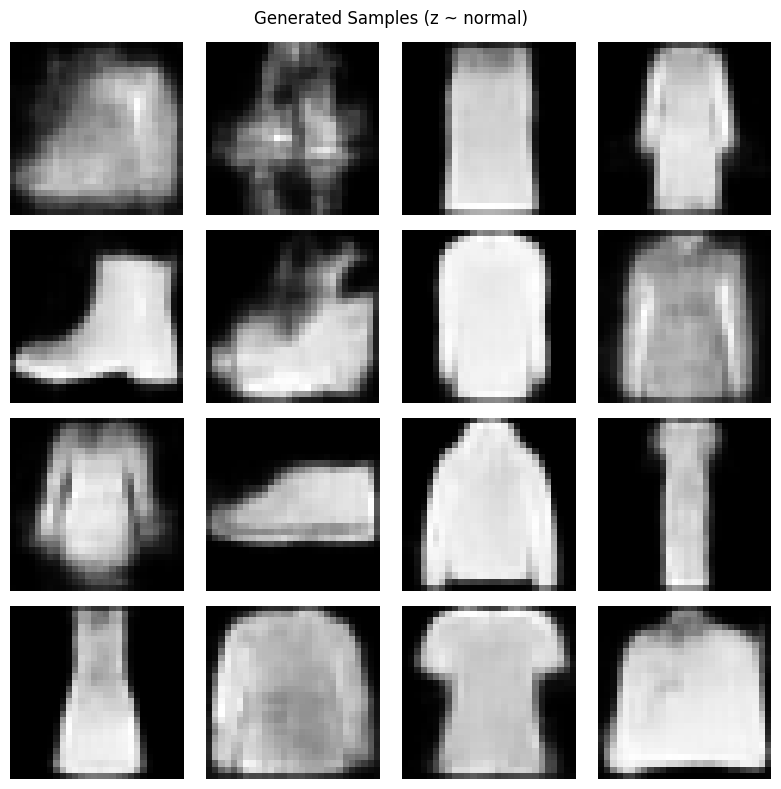

Analyzing posterior collapse for β-annealed VAE...
Posterior Collapse Analysis:
Mean μ across all samples: -0.002630 ± 0.026985
Mean log σ² across all samples: -0.898424 ± 1.277202
Mean σ across all samples: 0.750327 ± 0.308702
Ratio of posterior variances close to 1.0 (±0.1): 0.505


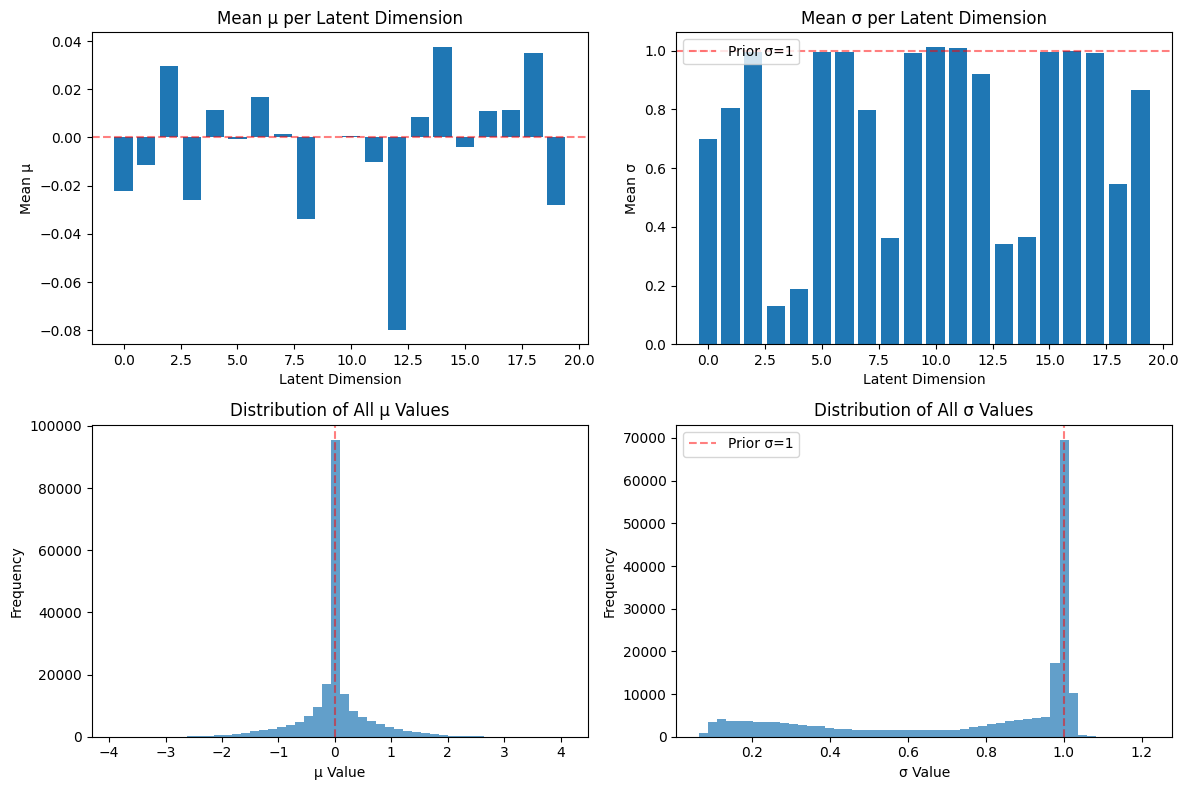


Posterior Collapse Comparison:
Standard VAE collapse ratio: 0.705
β-annealed VAE collapse ratio: 0.505
Improvement: 0.201

Testing cyclical β annealing...
Epoch   0 (β=1.000): Train Loss: 38.0835
Epoch  20 (β=1.000): Train Loss: 23.6336
Epoch  40 (β=1.000): Train Loss: 23.2471
Epoch  60 (β=1.000): Train Loss: 23.1090
Epoch  80 (β=1.000): Train Loss: 22.9980
Final comparison of all approaches:
Generating samples from all three models...
Standard VAE samples:


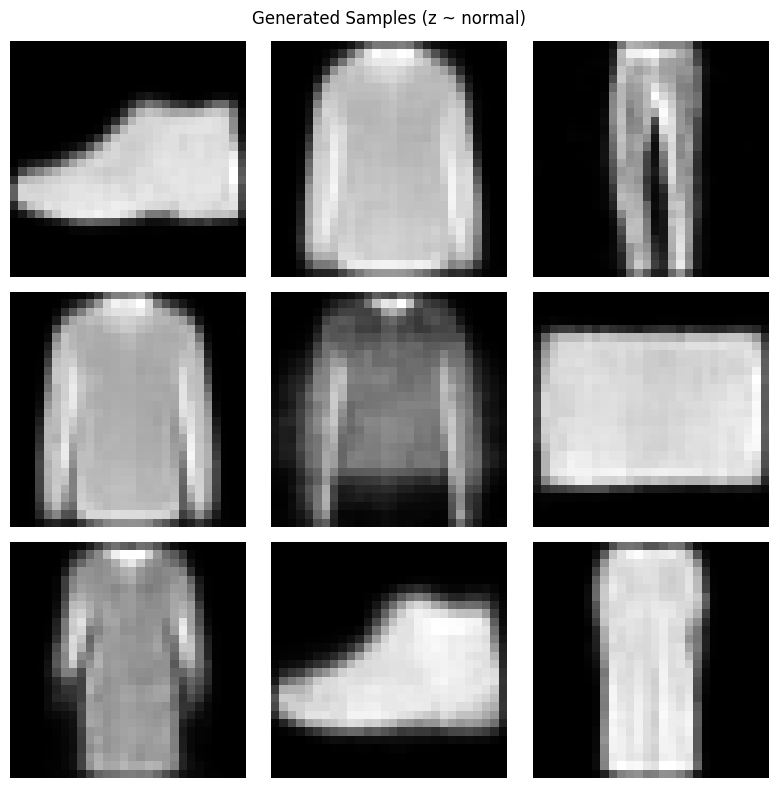

β-annealed VAE samples:


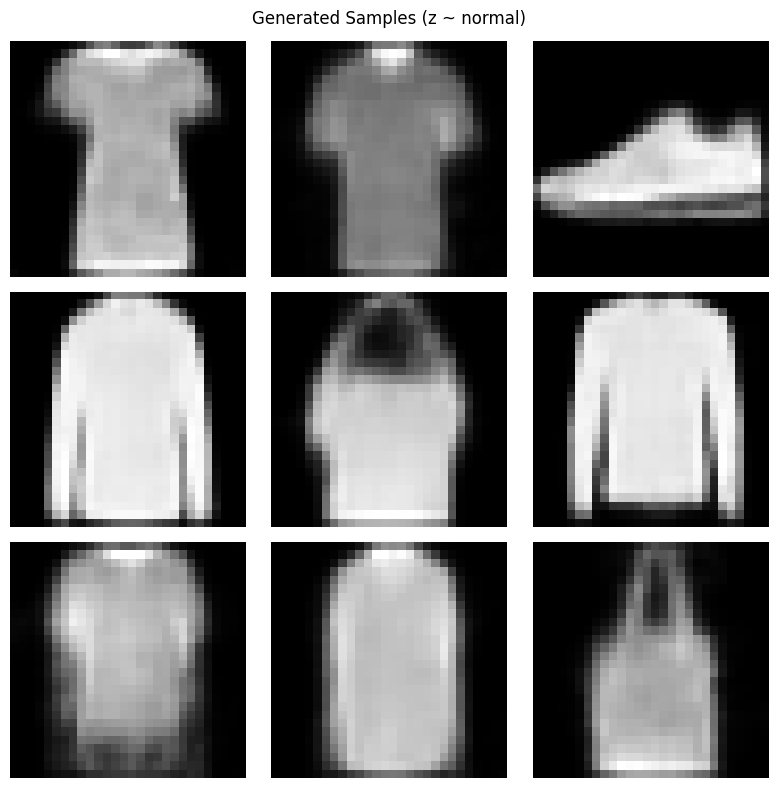

Cyclical β VAE samples:


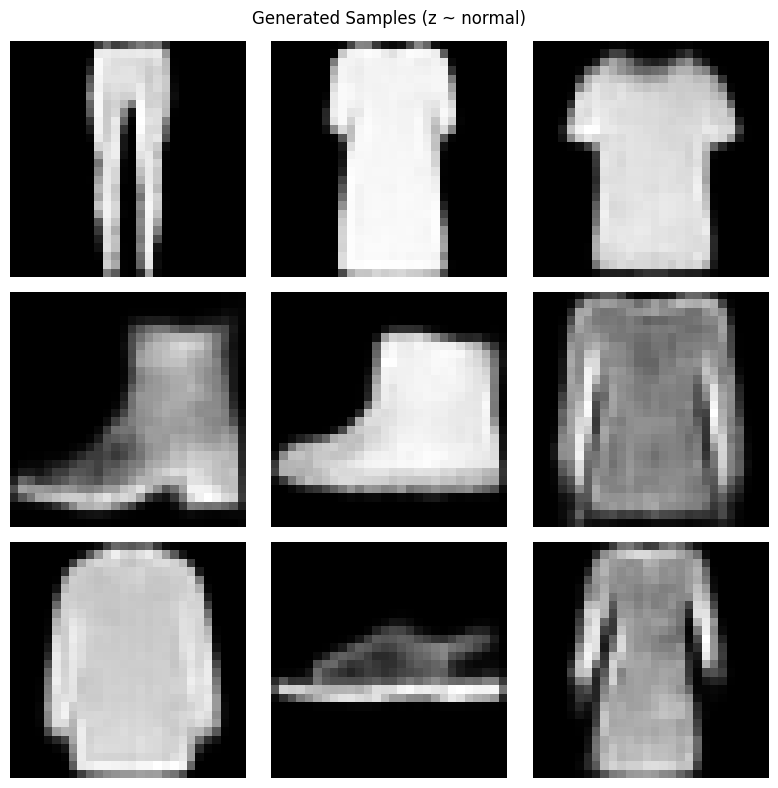

In [5]:

# ============================================================================
# TASK 4.4: MITIGATING POSTERIOR COLLAPSE
# ============================================================================

# Strategy 1: β-VAE with annealing
def train_vae_with_beta_annealing(model, train_loader, test_loader, epochs=100):
    """Train VAE with β annealing to mitigate posterior collapse"""
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    train_recon_losses = []
    train_kl_losses = []
    val_losses = []
    val_recon_losses = []
    val_kl_losses = []

    for epoch in range(epochs):
        # β annealing: start with β=0 and gradually increase to 1
        if epoch < 50:
            beta = 0.0  # No KL term for first 50 epochs
        else:
            beta = min(1.0, (epoch - 50) / 50.0)  # Linear annealing from 0 to 1

        total_loss = 0
        total_recon = 0
        total_kl = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()

        avg_train_loss = total_loss / len(train_dataset)
        avg_train_recon = total_recon / len(train_dataset)
        avg_train_kl = total_kl / len(train_dataset)

        train_losses.append(avg_train_loss)
        train_recon_losses.append(avg_train_recon)
        train_kl_losses.append(avg_train_kl)

        # Validation
        model.eval()
        val_loss = 0
        val_recon = 0
        val_kl = 0

        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
                val_loss += loss.item()
                val_recon += recon_loss.item()
                val_kl += kl_loss.item()

        avg_val_loss = val_loss / len(test_dataset)
        avg_val_recon = val_recon / len(test_dataset)
        avg_val_kl = val_kl / len(test_dataset)

        val_losses.append(avg_val_loss)
        val_recon_losses.append(avg_val_recon)
        val_kl_losses.append(avg_val_kl)

        model.train()

        if epoch % 10 == 0:
            print(f'Epoch {epoch:3d} (β={beta:.3f}): Train Loss: {avg_train_loss:.4f} '
                  f'(Recon: {avg_train_recon:.4f}, KL: {avg_train_kl:.4f}) | '
                  f'Val Loss: {avg_val_loss:.4f} '
                  f'(Recon: {avg_val_recon:.4f}, KL: {avg_val_kl:.4f})')

    return (train_losses, train_recon_losses, train_kl_losses,
            val_losses, val_recon_losses, val_kl_losses)

# Train VAE with β annealing
print("\nTraining VAE with β-annealing to mitigate posterior collapse...")
model_beta = VAE(latent_dim=20).to(device)
results_beta = train_vae_with_beta_annealing(model_beta, train_loader, test_loader, epochs=100)

plot_training_curves(results_beta, "VAE with β-annealing Training Curves")

# Compare results
print("Comparing standard VAE vs β-annealed VAE...")

print("\nReconstructions - Standard VAE:")
visualize_reconstructions(model, test_loader)

print("Reconstructions - β-annealed VAE:")
visualize_reconstructions(model_beta, test_loader)

print("Generations - Standard VAE:")
generate_samples(model, num_samples=16, distribution='normal')

print("Generations - β-annealed VAE:")
generate_samples(model_beta, num_samples=16, distribution='normal')

print("Analyzing posterior collapse for β-annealed VAE...")
collapse_ratio_beta = analyze_posterior_collapse(model_beta, test_loader)

print(f"\nPosterior Collapse Comparison:")
print(f"Standard VAE collapse ratio: {collapse_ratio_standard:.3f}")
print(f"β-annealed VAE collapse ratio: {collapse_ratio_beta:.3f}")
print(f"Improvement: {(collapse_ratio_standard - collapse_ratio_beta):.3f}")

# Additional strategy: Cyclical β annealing
def train_vae_cyclical_beta(model, train_loader, test_loader, epochs=100):
    """Train VAE with cyclical β annealing"""
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Cyclical β: cycles between 0 and 1 every 20 epochs
        cycle_length = 20
        cycle_position = (epoch % cycle_length) / cycle_length
        beta = 0.5 * (1 + np.cos(np.pi * cycle_position))  # Cosine annealing

        total_loss = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, mu, logvar = model(data)
            loss, _, _ = vae_loss(recon_batch, data, mu, logvar, beta)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_losses.append(total_loss / len(train_dataset))

        if epoch % 20 == 0:
            print(f'Epoch {epoch:3d} (β={beta:.3f}): Train Loss: {total_loss / len(train_dataset):.4f}')

    return train_losses

print("\nTesting cyclical β annealing...")
model_cyclical = VAE(latent_dim=20).to(device)
cyclical_losses = train_vae_cyclical_beta(model_cyclical, train_loader, test_loader, epochs=100)

print("Final comparison of all approaches:")
print("Generating samples from all three models...")

print("Standard VAE samples:")
generate_samples(model, num_samples=9, distribution='normal')

print("β-annealed VAE samples:")
generate_samples(model_beta, num_samples=9, distribution='normal')

print("Cyclical β VAE samples:")
generate_samples(model_cyclical, num_samples=9, distribution='normal')